## BSA fitting using bins in Phi - using ROOReal

The purpose of this file is to do BSA fitting for RGA data selected for Exclusive Rho using bins in phi instead of a MLM fit

$$\frac{d\sigma_+-d\sigma_-}{d\sigma_+ + d\sigma_- }  = \alpha \sin \phi$$
where 
$$ \alpha = \frac{\sqrt{2\epsilon (1-\epsilon)}F_{LU}^{\sin \phi}}{F_{UU}} $$

In [1]:
import ROOT
from ROOT import RooRealVar, RooArgSet, RooDataSet, RooAbsPdf, RooFit, TMath, RooDataHist,RooDataSet
import os
import numpy as np
import uproot
import array

In [2]:
inputFiles = ["out/pippi0_fall2018_in_pass2/pippi0_fall2018_in_pass2.root","out/pippi0_spring2019_in_pass2/pippi0_spring2019_in_pass2.root"]

In [ ]:

# Initialize empty lists to collect data
all_phi = []
all_z = []
all_hel = []
all_Mx = []
all_Mdiphoton = []
all_eps = []


for f in inputFiles:
    file = uproot.open(f)
    tree = file["pippi0"]
    branches = tree.arrays(["phi", "z", "hel", "Mx", "Mdiphoton", "eps","Mh"], library="np")
    all_phi.append(branches["phi"])
    all_z.append(branches["z"])
    all_hel.append(branches["hel"])
    all_Mx.append(branches["Mx"])
    all_Mdiphoton.append(branches["Mdiphoton"])
    all_eps.append(branches["eps"])


phi_vals = np.concatenate(all_phi)
z_vals = np.concatenate(all_z)
hel_vals = np.concatenate(all_hel)
Mx_vals = np.concatenate(all_Mx)
Mdiphoton_vals = np.concatenate(all_Mdiphoton)
eps_vals = np.concatenate(all_eps)


In [ ]:
mask = (
    (branches["Mdiphoton"] > 0.115) & (branches["Mdiphoton"] < 0.16) &
    (branches["Mx"] > 0.85) & (branches["Mx"] < 1.05)
)

phi_vals = branches["phi"][mask]
z_vals = branches["z"][mask]
hel_vals = branches["hel"][mask]
eps_vals = branches["eps"][mask]
Mh_vals = branches["Mh"][mask]


In [ ]:
print(len(phi_vals))

Warning in <TROOT::Append>: Replacing existing TH1: binning (Potential memory leak).


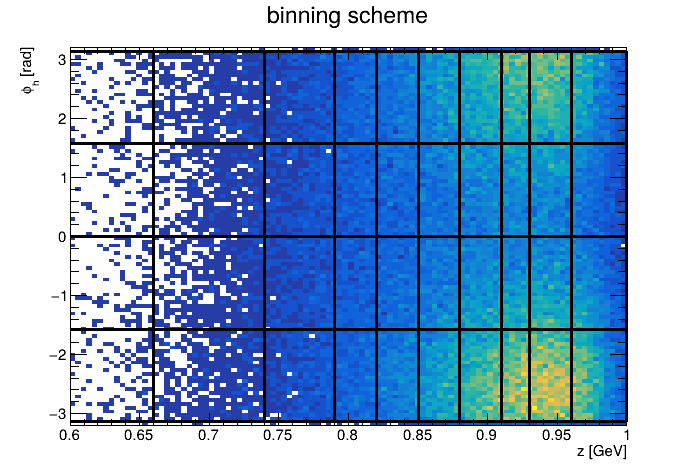

In [38]:
zbn_edges = [0.66, 0.74, 0.79, 0.82, 0.85, 0.88, 0.91, 0.93, 0.96, 1]
phibn_edges = np.linspace(-3.14,3.14,5)

c2D = ROOT.TCanvas()
c2D.SetTickx()
c2D.SetTicky()
#c2D.SetGridx()
#c2D.SetGridy()

binning = ROOT.TH2F("binning","binning scheme;z [GeV];#phi_{h} [rad]", 
                    100,0.6,1,
                    100,-3.2,3.2)
for idx in range(len(z_vals)):
    binning.Fill(z_vals[idx],phi_vals[idx])

binning.SetStats(0)
binning.Draw()

lines = []

for z in zbn_edges:
    line = ROOT.TLine(z, -3.14, z, 3.14)
    line.SetLineColor(ROOT.kBlack)
    line.SetLineWidth(3)
    line.Draw()
    lines.append(line)

for phi in phibn_edges:
    line = ROOT.TLine(0.6, phi, 1, phi)
    line.SetLineColor(ROOT.kBlack)
    line.SetLineWidth(3)
    line.Draw()
    lines.append(line)

c2D.Draw()



In [55]:
#create RooReal variables
Mh = RooRealVar("Mh", "Mh", 0.4, 1.7)


N = RooRealVar("N", "N", 0, 1.5)
mu = RooRealVar("mu", "mu", 0.8,0.6, 1)
sig = RooRealVar("sig", "sig", 0.06,0, 1)
alphal = RooRealVar("alphal", "alphal", 1.57,-100,100)
alphah = RooRealVar("alphah", "alphah", 0.9,-100,100)
nl = RooRealVar("nl", "nl", 1.7,0,10)
nh = RooRealVar("nh", "nh", 5,0,10)
p0 = RooRealVar("p0", "p0", -0.011,-1,1)
p1 = RooRealVar("p1", "p1", 0.00624,-1,1)
p2 = RooRealVar("p2", "p2", 0.8321,-1,1)
p3 = RooRealVar("p3", "p3", -0.912017,-1,1)
p4 = RooRealVar("p4", "p4", 0.25,-1,1)
pars = ROOT.RooArgList(N,mu,sig,alphal,alphah,nl,nh,p0,p1,p2,p3,p4)
pars_dcb = ROOT.RooArgList(N,mu,sig,alphal,alphah,nl,nh)
pars_pol = ROOT.RooArgList(p0,p1,p2,p3,p4)


In [56]:
# Create left and right Crystal Ball components
cb_left = ROOT.RooCBShape("cb_left", "Left CB", Mh, mu, sig, alphal, nl)
cb_right = ROOT.RooCBShape("cb_right", "Right CB", Mh, mu, sig, alphah, nh)

# Combine them into a Double Crystal Ball
frac_cb = ROOT.RooRealVar("frac_cb", "Fraction of left CB", 0.5, 0.0, 1.0)
dcb = ROOT.RooAddPdf("dcb", "Double Crystal Ball", cb_left, cb_right, frac_cb)

# Background: 4th-order polynomial
coeffs = []
poly_terms = ROOT.RooArgList()
for i in range(5):
    coeff = ROOT.RooRealVar(f"c{i}", f"c{i}", 0.0, -10.0, 10.0)
    coeffs.append(coeff)
    poly_terms.add(coeff)

background = ROOT.RooPolynomial("background", "Background", Mh, poly_terms)

# Combine signal and background
u = ROOT.RooRealVar("frac_signal", "Signal fraction", 0.5, 0.0, 1.0)
model = ROOT.RooAddPdf("model", "Signal + Background", dcb, background, u)


In [58]:

ratio_list = []
zbn_centers = []
phibn_centers = []

#iterate through every z bin
for i in range(len(zbn_edges) - 1):
    zmin, zmax = zbn_edges[i], zbn_edges[i+1]
    zbin_mask = (z_vals > zmin) & (z_vals < zmax)

    phi_zbinned = phi_vals[zbin_mask]
    hel_zbinned = hel_vals[zbin_mask]
    eps_zbinned = eps_vals[zbin_mask]
    Mh_zbinned = Mh_vals[zbin_mask]

    #bin in phi to find Number of signal Rho events with respect to phi
    for j in range(1):#range(len(phibn_edges)-1):
        phimin,phimax = phibn_edges[j],phibn_edges[j+1]
        phibin_mask = (phi_zbinned > phimin) & (phi_zbinned < phimax)

        Mh_phibinned = Mh_zbinned[phibin_mask]
        hel_phibinned = hel_zbinned[phibin_mask]
        
        #separate by helicity:
        Mh_neg = Mh_phibinned[hel_phibinned ==-1]
        Mh_pos = Mh_phibinned[hel_phibinned ==1]

        # Fill histograms
        h_neg = ROOT.TH1F("h_neg", "h_neg;Mh_h", 100, 0.2, 1.8)
        h_pos = ROOT.TH1F("h_pos", "h_pos;Mh_h", 100, 0.2, 1.8)
        for val in Mh_neg:
            h_neg.Fill(val)
        for val in Mh_pos:
            h_pos.Fill(val)

        #normalize:
        h_neg = normalize(h_neg)
        h_pos = normalize(h_pos)

        #setup the data variable to be fit
        data_neg = RooDataHist("data_neg", "data", ROOT.RooArgList(Mh), h_neg)
        data_pos = RooDataHist("data_pos", "data", ROOT.RooArgList(Mh), h_pos)

        #fit to find number of sig events within this bin
        neg_result = model.fitTo(data_neg,RooFit.Save())
        print("\n")
        print("--------------------------------------------------------------------------------------------------------------------")
        print("\n")
        neg_result.Print()
        model.fitTo(data_pos)
        params_pos = [pars.at(i).getVal() for i in range(12)]
    
        #define functions based on parameters
        cb_func_neg = ROOT.TF1("cb_func_neg",d_crystalball,0.4,1.7,7)
        cb_func_neg.SetParameters(params_neg[0],params_neg[1],params_neg[2],params_neg[3],params_neg[4],params_neg[5],params_neg[6])
        cb_func_neg.SetLineColor(ROOT.kBlue)
    
        pol4_func_neg = ROOT.TF1("pol4_func_neg",polynomial,0.4,1.7,5)
        pol4_func_neg.SetParameters(params_neg[7],params_neg[8],params_neg[9],params_neg[10],params_neg[11])
        pol4_func_neg.SetLineColor(ROOT.kRed)

        cb_func_pos = ROOT.TF1("cb_func_pos",d_crystalball,0.4,1.7,7)
        cb_func_pos.SetParameters(params_pos[0],params_pos[1],params_pos[2],params_pos[3],params_pos[4],params_pos[5],params_pos[6])
        cb_func_pos.SetLineColor(ROOT.kBlue)
    
        pol4_func_pos = ROOT.TF1("pol4_func_pos",polynomial,0.4,1.7,5)
        pol4_func_pos.SetParameters(params_pos[7],params_pos[8],params_pos[9],params_pos[10],params_pos[11])
        pol4_func_pos.SetLineColor(ROOT.kRed)

        c = ROOT.TCanvas("c","c",1200,600)
        leg_neg = ROOT.TLegend(0.65,0.75,0.85,0.85)
        leg_neg.AddEntry("h_neg","neg hel data","l")
        leg_neg.AddEntry("cb_func_neg","neg hel sig","l")
        leg_neg.AddEntry("pol4_func_pos","neg hel bkg","l")

        leg_pos = ROOT.TLegend(0.65,0.75,0.85,0.85)
        leg_pos.AddEntry("h_pos","pos hel data","l")
        leg_pos.AddEntry("cb_func_pos","pos hel sig","l")
        leg_pos.AddEntry("pol4_func_pos","pos hel bkg","l")

        h_neg.SetStats(0)
        h_pos.SetStats(0)

        c.Divide(2)
        c.cd(1)
        h_neg.Draw()
        cb_func_neg.Draw("SAME")
        pol4_func_neg.Draw("SAME")
        leg_neg.Draw()
        c.cd(2)
        h_pos.Draw()
        cb_func_pos.Draw("SAME")
        pol4_func_pos.Draw("SAME")
        leg_pos.Draw()
        c.Draw()
        c.SaveAs(f"out/test/g{i}_{j}.png")
        

        #integrate signal curve to find the total number of rho events of each helicity

        #find proper ratio of helicity cross sections (scaled by polarization)

        #save to a list for plotting with respect to sin phi to fit linearly


    # Fit and calculate asymmetry
    #c, A_val = fitToSin(h_neg, h_pos, -3.14, 3.14)

    #eps_avg = np.mean(eps_zbinned)
    #depolarization = np.sqrt(2 * eps_avg * (1 - eps_avg))
    #ratio_list.append(A_val / depolarization)
    #zbn_centers.append((zmin + zmax) / 2)

    

/n
--------------------------------------------------------------------------------------------------------------------
/n


ReferenceError: attempt to access a null-pointer

[#1] INFO:Fitting -- RooAbsPdf::fitTo(model) fixing normalization set for coefficient determination to observables in data
[#0] WARNING:InputArguments -- RooAbsPdf::fitTo(model): WARNING: a likelihood fit is requested of what appears to be weighted data.
       While the estimated values of the parameters will always be calculated taking the weights into account,
       there are multiple ways to estimate the errors of the parameters. You are advised to make an
       explicit choice for the error calculation:
           - Either provide SumW2Error(true), to calculate a sum-of-weights-corrected HESSE error matrix
             (error will be proportional to the number of events in MC).
           - Or provide SumW2Error(false), to return errors from original HESSE error matrix
             (which will be proportional to the sum of the weights, i.e., a dataset with <sum of weights> events).
           - Or provide AsymptoticError(true), to use the asymptotically correct expression
      

Warning in <TROOT::Append>: Replacing existing TH1: h_neg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -1.895299111 Edm =      0.8905082009 NCalls =     63
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : -1.895769643
  Edm           : 0.8373353895
  Internal parameters:	[      1.421180935     -1.554282276    -0.3002986881    0.04679254133     0.3238911299   -0.02722416345   -0.03729554722    -0.8974528614     0.8270213019   -0.01063105756....     -0.8272905554]	
  Internal gradient  :	[                0                0     -120843.9461     -98030.66393     -81175.59749     -132463.9734     -256387.4907                0     -1.43098685

In [ ]:
x = 
y = 
x = np.zeroeslike(x)
y = np.zeroeslike(y)

gr = ROOT.TGraphErrors(len(x),x,y,xerr,yerr)

In [ ]:
RunPlotting(ratio_list,zbn_centers,
                "RGA_inbending", "F_{LU}^{sin#phi}/F_{UU}",
                "z")

In [ ]:
print(len(zbn_centers),len(ratio_list))